# Resolving Power Filters (FTICR)

A brief demonstration of the resolving power filters available in CoreMS. 

In [1]:
# Import key CoreMS and other functions
from corems.encapsulation.factory.parameters import MSParameters
from corems.transient.input.brukerSolarix import ReadBrukerSolarix
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.mass_spectrum.calc.MeanResolvingPowerFilter import MeanResolvingPowerFilter

In [17]:
# Import Python libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')

In [3]:
# Define the dataset location, here use an example file: 
file_location = '../../tests/tests_data/ftms/NEG_ESI_SRFA_Auto.d'
magnet_field = 15 # 15 Tesla dataset

In [4]:
# Define the settings for peak picking and noise thresholding to use
def set_other_params():
    MSParameters.mass_spectrum.noise_threshold_method = 'log' 
    MSParameters.mass_spectrum.noise_threshold_log_nsigma = 8
    MSParameters.ms_peak.legacy_resolving_power = False
    MSParameters.mass_spectrum.picking_point_extrapolate = 0 
    MSParameters.ms_peak.peak_min_prominence_percent = 0.001
    MSParameters.mass_spectrum.noise_min_mz = 150
    MSParameters.mass_spectrum.noise_max_mz = 800
    MSParameters.mass_spectrum.min_picking_mz = 150
    MSParameters.mass_spectrum.max_picking_mz = 800
    MSParameters.transient.number_of_zero_fills = 1

In [5]:
# Start the bruker parser
bruker_reader = ReadBrukerSolarix(file_location)

# Set the peak picking/noise threshold
set_other_params()

# Get the transient object
transient = bruker_reader.get_transient()

# Read the mass spectrum
mass_spectrum = transient.get_mass_spectrum(plot_result=False, auto_process=True)

In [6]:
# export the masss spectrum object to a dataframe
msdf = mass_spectrum.to_dataframe()
print(f"There were {len(msdf)} peaks detected")

There were 12608 peaks detected


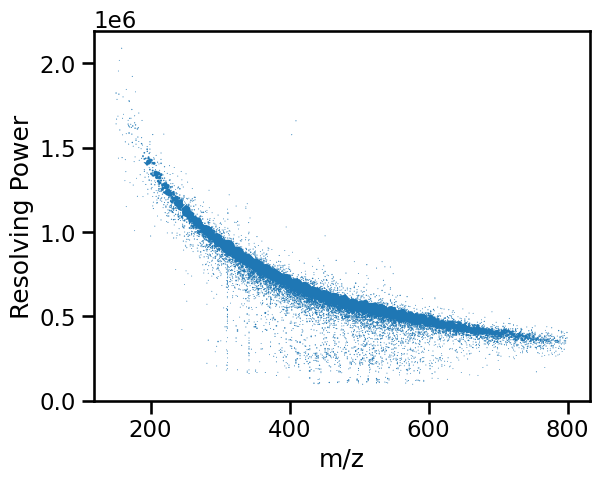

In [7]:
# Plot the masses against resolving powers for all the picked peaks
sns.scatterplot(data =msdf, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=msdf['S/N']/25)
original_data = msdf[['m/z','Resolving Power','S/N']].copy()

In [8]:
transienth_length = transient.cal_transient_time() 
print(f"The transient length was {transienth_length} seconds.")

apodization_method = transient.parameters.apodization_method
print(f"The apodization method was {apodization_method}.")

print(f"The magnet field was {magnet_field} T.")

The transient length was 2.5165824 seconds.
The apodization method was Hanning.
The magnet field was 15 T.


There were 7425 peaks after filtering with a tolerance of 10.0%


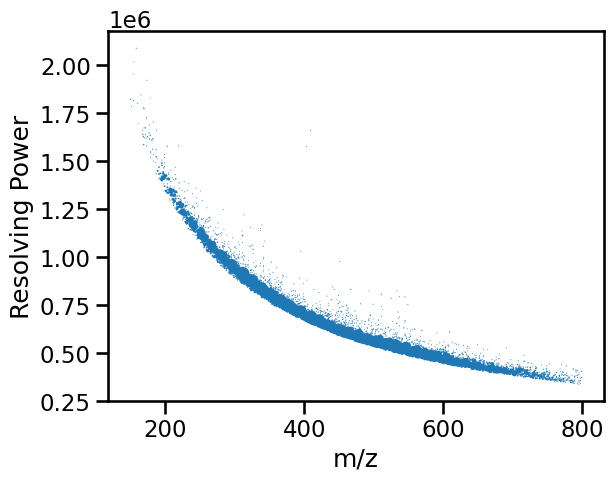

In [9]:
tolerance = 0.10

mass_spectrum.filter_by_min_resolving_power(magnet_field, transienth_length, apodization_method=apodization_method, tolerance = tolerance)

# export the masss spectrum object to a dataframe
msdf = mass_spectrum.to_dataframe()

print(f"There were {len(msdf)} peaks after filtering with a tolerance of {tolerance*100}%")

# Plot the masses against resolving powers for all the picked peaks
sns.scatterplot(data =msdf, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=msdf['S/N']/25)
theoretical_filter_data = msdf[['m/z','Resolving Power','S/N']].copy()

### Evidently, the theoretical reoslving power - even with a 10% threshold - can filter out a lot of real peaks we want. 
#### Two issues exist - one is the apodisation calculation is not mathematically rigorous - that is on a to-do list 
#### The other is that real data isnt perfect.

As an alternative, we can use a MeanResolvingPower Filter

This normalises the resolving powers by m/z (For ICR), and then calculates the mean and standard deviation, and calculates a list of indexes which are outside this tolerance to filter out. 

In [10]:
from corems.mass_spectrum.calc.MeanResolvingPowerFilter import MeanResolvingPowerFilter
# Read the mass spectrum
mass_spectrum = transient.get_mass_spectrum(plot_result=False, auto_process=True)

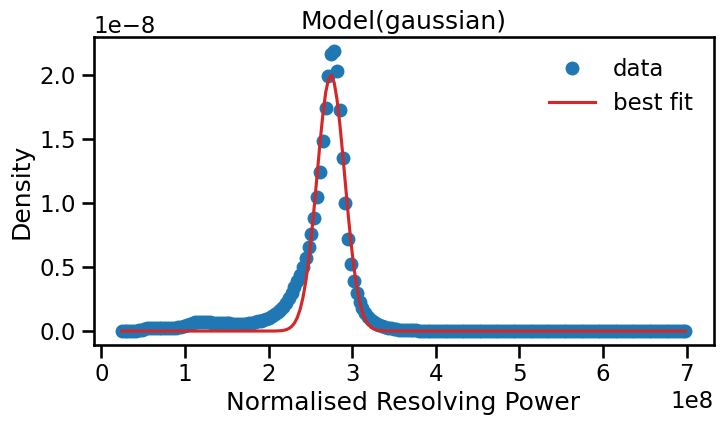

In [11]:
idx_to_remove, rps_thresh,mean_res,std_res = MeanResolvingPowerFilter(mass_spectrum, plot=True, return_rps=True).main()

In [12]:
print(f"There were {len(idx_to_remove)} peaks detected to be filtered")

There were 1369 peaks detected to be filtered


There were 11239 peaks after filtering by the mean filter and a default of 3 standard deviations


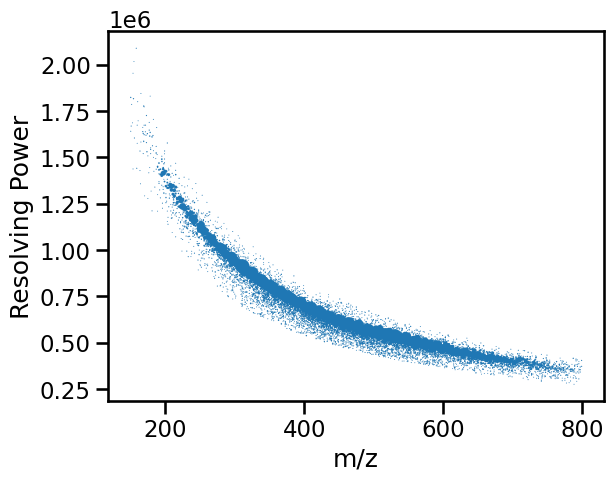

In [13]:
mass_spectrum.filter_by_index(idx_to_remove)

# export the masss spectrum object to a dataframe
msdf = mass_spectrum.to_dataframe()

print(f"There were {len(msdf)} peaks after filtering by the mean filter and a default of 3 standard deviations")

# Plot the masses against resolving powers for all the picked peaks
sns.scatterplot(data =msdf, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=msdf['S/N']/25)
mean_filter_data = msdf[['m/z','Resolving Power','S/N']].copy()

<Axes: xlabel='m/z', ylabel='Resolving Power'>

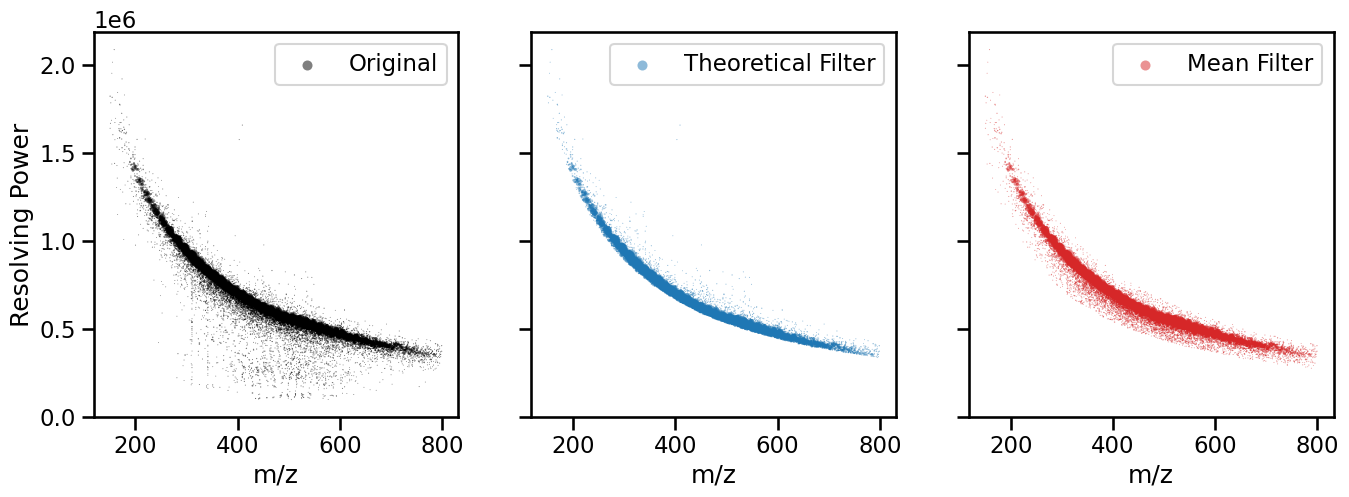

In [18]:
fig,axes = plt.subplots(figsize = (16,5), sharex=True,sharey=True, ncols=3)
sns.scatterplot(data =original_data, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=original_data['S/N']/25, alpha=0.5, c='k', label='Original', ax=axes[0])
sns.scatterplot(data =theoretical_filter_data, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=theoretical_filter_data['S/N']/25, alpha=0.5, c='tab:blue', label='Theoretical Filter', ax=axes[1])
sns.scatterplot(data =mean_filter_data, x = 'm/z', y = 'Resolving Power', edgecolor=None, s=mean_filter_data['S/N']/25, alpha=0.5, c='tab:red', label='Mean Filter', ax=axes[2])
